In [1]:
import sys
import tensorflow as tf
import keras
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, BatchNormalization, Flatten, Dense, Dropout
from keras import optimizers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from keras import backend as K
from pdb import set_trace

Using TensorFlow backend.


In [2]:
batch_size = 512
channels = 3
img_height = 30
img_width = 50
classes = 4 #5 #6
class_names = np.array(['gamma', 'electron', 'muon', 'pion_c'])
epochs = 100 #15
dataset_dir = 'data/pkl/'
save_dir = 'saved_models/'
plotdir = 'plots/'

model_name='full_model'
history_name='full_model_history'

In [3]:
# Load the data
train_dat = pd.read_pickle(dataset_dir + "dataset_train.pkl")
test_dat = pd.read_pickle(dataset_dir + "dataset_test.pkl")

print('Loading training data...')
train_dat = train_dat.query("label!=3")
train_dat = train_dat.query("label!=4")
# slt = train_dat.label>3
slt = train_dat.label==5
# slt2 = (train_dat.label==1) | (train_dat.label==2) 
# train_dat.loc[slt2,"label"] -= 1
train_dat.loc[slt,"label"] -= 2 #3 #1
train_dat.reset_index(drop=True,inplace=True)

x_train, pid_train, en_train = [],[],[]

x_train.append(train_dat.feature)
x_train = np.array(x_train)
x_train = x_train[0]

pid_train.append(train_dat.label)
pid_train = np.array(pid_train)
pid_train = pid_train[0]
pid_train = keras.utils.to_categorical(pid_train, num_classes=classes, dtype='float32')

en_train.append(train_dat.gen_energy)
en_train = np.array(en_train)
en_train = en_train[0]

####### NORMALIZE THE ENERGY ########

mean_en = np.mean(en_train)
std_en = np.std(en_train)
print('Mean Energy Value: {}'.format(mean_en))
print('Std Energy Value: {}'.format(std_en))

en_train_norm = (en_train - mean_en)/std_en
print(x_train.shape)
print(pid_train.shape)
print(en_train.shape)

Loading training data...
Mean Energy Value: 213.7548908474823
Std Energy Value: 108.07517139799974
(35999, 50, 30, 3)
(35999, 4)
(35999,)


In [4]:
print('Loading test data...')
test_dat = test_dat.query("label!=3") #drop tau
test_dat = test_dat.query("label!=4") #drop pi0
# slt = test_dat.label>3
slt = test_dat.label==5
# slt2 = (test_dat.label==1) | (test_dat.label==2) 
# test_dat.loc[slt2,"label"] -= 1 #merge e-gamma and shift muon label
test_dat.loc[slt,"label"] -= 2 #3 #1 #shift  pi+ labels
test_dat.reset_index(drop=True,inplace=True)

x_test, pid_test, en_test = [],[],[]

x_test.append(test_dat.feature)
x_test = np.array(x_test)
x_test = x_test[0]

pid_test.append(test_dat.label)
pid_test = np.array(pid_test)
pid_test = pid_test[0]
pid_test_label = pid_test
pid_test = keras.utils.to_categorical(pid_test, num_classes=classes, dtype='float32')

en_test.append(test_dat.gen_energy)
en_test = np.array(en_test)
en_test = en_test[0]

gamma_true_en = en_test[pid_test_label==0]
electron_true_en = en_test[pid_test_label==1]
muon_true_en = en_test[pid_test_label==2]
pion_c_true_en = en_test[pid_test_label==3]

####### NORMALIZE THE ENERGY ########
en_test_norm = (en_test - mean_en)/std_en

print(x_test.shape)
print(pid_test.shape)
print(en_test.shape)

Loading test data...
(4001, 50, 30, 3)
(4001, 4)
(4001,)


In [5]:
def full_model():
        input_img = Input(shape=(img_width, img_height, channels), name='input')
        
        bnorm = BatchNormalization()(input_img)
        conv = Conv2D(16, (5,1), activation='relu', padding='same', kernel_initializer='random_uniform', data_format='channels_last', name='conv1')(bnorm)
        conv = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='random_uniform', data_format='channels_last', name='conv2')(conv)
        conv = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='random_uniform', data_format='channels_last', name='conv3')(conv)

        flat = Flatten()(conv)
        # bnorm = BatchNormalization()(flat)

        dense = Dense(1024, activation='relu', kernel_initializer='random_uniform', name='dense1')(flat)
        dense = Dense(256, activation='relu', kernel_initializer='random_uniform', name='dense2')(dense)

        dense_id = Dense(64, activation='relu', kernel_initializer='random_uniform', name='dense_id1')(dense)
        dense_id = Dense(16, activation='relu', kernel_initializer='random_uniform', name='dense_id2')(dense_id)
        pid = Dense(classes, activation='softmax', kernel_initializer='random_uniform', name='pid_output')(dense_id)

        dense_er = Dense(64, activation='relu', kernel_initializer='random_uniform', name='dense_er1')(dense)
        dense_er = Dense(8, activation='relu', kernel_initializer='random_uniform', name='dense_er2')(dense_er)
        enreg = Dense(1, name='enreg_output')(dense_er)

        model = Model(inputs=input_img, outputs=[pid, enreg])

        # opt = optimizers.Adam(lr=0.01)
        model.compile(loss={'pid_output': 'categorical_crossentropy', 'enreg_output': 'mse'}, loss_weights={'pid_output': 1, 'enreg_output': 1}, optimizer='adam', metrics={'pid_output': 'accuracy', 'enreg_output': 'mse'})
        return model

In [6]:
print('Creating model...')
model = full_model()
model.summary()

history = model.fit(x_train, {'pid_output': pid_train, 'enreg_output': en_train_norm}, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)], shuffle=True, verbose=1)
history_save = pd.DataFrame(history.history).to_hdf(save_dir + history_name + ".h5", "history", append=False)


Creating model...
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 30, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 30, 3)    12          input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 30, 16)   256         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 50, 30, 16)   2320        conv1[0][0]                      
___________________

Epoch 13/100
32399/32399 [==============================] - 22s 668us/step - loss: 0.5848 - pid_output_loss: 0.3389 - enreg_output_loss: 0.2459 - pid_output_acc: 0.8106 - enreg_output_mean_squared_error: 0.2459 - val_loss: 0.5954 - val_pid_output_loss: 0.3512 - val_enreg_output_loss: 0.2442 - val_pid_output_acc: 0.8069 - val_enreg_output_mean_squared_error: 0.2442
Epoch 14/100
32399/32399 [==============================] - 22s 675us/step - loss: 0.5935 - pid_output_loss: 0.3374 - enreg_output_loss: 0.2561 - pid_output_acc: 0.8093 - enreg_output_mean_squared_error: 0.2561 - val_loss: 0.6723 - val_pid_output_loss: 0.3552 - val_enreg_output_loss: 0.3171 - val_pid_output_acc: 0.8047 - val_enreg_output_mean_squared_error: 0.3171
Epoch 15/100
32399/32399 [==============================] - 22s 671us/step - loss: 0.5972 - pid_output_loss: 0.3318 - enreg_output_loss: 0.2654 - pid_output_acc: 0.8165 - enreg_output_mean_squared_error: 0.2654 - val_loss: 0.6157 - val_pid_output_loss: 0.3548 - val_

In [7]:
# Save model and weights
model.save(save_dir + model_name + ".h5")
print('Saved trained model at %s ' % save_dir)


Saved trained model at saved_models/ 


In [8]:
# save the frozen model
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, save_dir, model_name + ".pbtxt", as_text=True)
tf.train.write_graph(frozen_graph, save_dir, model_name + ".pb", as_text=False)

print('Model saved')

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 107 variables.
INFO:tensorflow:Converted 107 variables to const ops.
Model saved


In [9]:
# Score trained model

scores = model.evaluate(x_test, {'pid_output': pid_test, 'enreg_output': en_test_norm}, verbose=1)
print("Scores: {}".format(scores))

4001/4001 [==============================] - 2s 600us/step
Scores: [0.6059102188778114, 0.36207368799676254, 0.243836531465395, 0.7973006748312922, 0.243836531465395]


In [10]:
results = model.predict(x_test)

# energy_results = model_2.predict([reco_en_test, pid_results])
print('*****************')

print('****** PID START*******')
print('True Particle IDs= {} '.format(pid_test))
pid_results = results[0]
print('Predicted Particle IDs= {} '.format(pid_results))
print('****** PID END*******')

print('****** ENREG START*******')
print('True Particle Energies= {} '.format(en_test))
enreg_results = results[1]
enreg_results = (enreg_results * std_en) + mean_en
print('Predicted Particle Energies= {}'.format(enreg_results))
print('****** ENREG END*******')

*****************
****** PID START*******
True Particle IDs= [[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]] 
Predicted Particle IDs= [[5.4297325e-05 7.5386702e-06 2.2534884e-06 9.9993587e-01]
 [5.6747568e-01 4.3184885e-01 4.3486325e-06 6.7113002e-04]
 [7.6987642e-01 2.2802342e-01 1.7782068e-07 2.0999350e-03]
 ...
 [1.6845754e-04 2.5691321e-05 4.5345109e-06 9.9980134e-01]
 [5.7948709e-01 4.1944671e-01 8.5469774e-06 1.0576769e-03]
 [1.4398326e-05 4.5695906e-05 9.9884367e-01 1.0962024e-03]] 
****** PID END*******
****** ENREG START*******
True Particle Energies= [313.06610107 126.85121155  31.54555893 ... 195.74960327  54.78979492
 189.31274414] 
Predicted Particle Energies= [[316.3652 ]
 [131.52484]
 [ 32.11624]
 ...
 [178.2533 ]
 [ 51.90532]
 [249.24355]]
****** ENREG END*******


In [11]:
pid_true = np.argmax(pid_test, axis=1)
pid_pred = np.argmax(pid_results, axis=1)

In [12]:
print(pid_true)
print(pid_pred)

[3 0 1 ... 3 0 2]
[3 0 0 ... 3 0 2]


In [13]:
en_true = en_test
en_pred = enreg_results

In [14]:
en_pred = np.squeeze(en_pred)
print(en_true)
print(en_pred)

[313.06610107 126.85121155  31.54555893 ... 195.74960327  54.78979492
 189.31274414]
[316.3652  131.52484  32.11624 ... 178.2533   51.90532 249.24355]


In [15]:
gamma_reco_en = en_pred[pid_test_label==0]
electron_reco_en = en_pred[pid_test_label==1]
muon_reco_en = en_pred[pid_test_label==2]
pion_c_reco_en = en_pred[pid_test_label==3]

In [16]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
    plt.yticks(tick_marks, classes, fontsize=7)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=7)

    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

Normalized confusion matrix
[[0.66 0.33 0.   0.  ]
 [0.45 0.55 0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.02 0.   0.   0.98]]


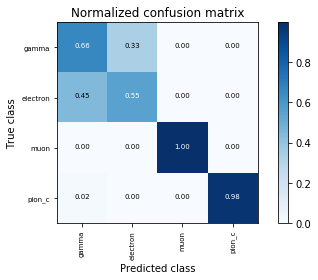

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(pid_true, pid_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(0)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.savefig(plotdir + 'confusion_matrix.png')
plt.show()

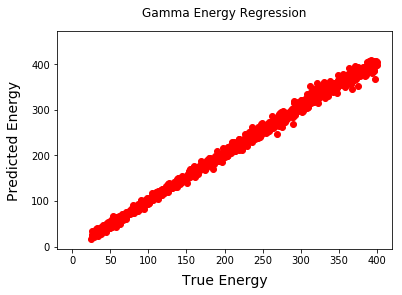

In [18]:
#gamma's energy
fig1 = plt.figure(1)
plt.scatter(gamma_true_en, gamma_reco_en, color='red')
plt.plot([0,0],[450,450], color="black", linestyle='solid')
plt.title('Gamma Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.savefig(plotdir + 'gammaEn.png')
fig1.show()

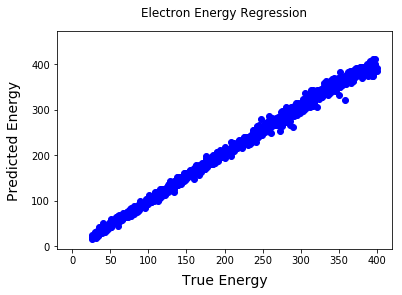

In [19]:
#electron's energy
fig2 = plt.figure(2)
plt.scatter(electron_true_en, electron_reco_en, color='blue')
plt.plot([0,0],[450,450], color="black", linestyle='-')
plt.title('Electron Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.savefig(plotdir + 'electronEn.png')
fig2.show()

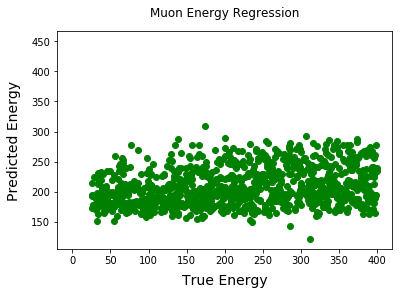

In [20]:
#muon's energy
fig3 = plt.figure(3)
plt.scatter(muon_true_en, muon_reco_en, color='green')
plt.plot([0,0],[450,450], color="black", linestyle='-')
plt.title('Muon Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.savefig(plotdir + 'muonEn.png')
fig1.show()

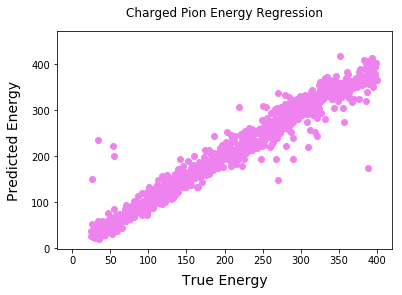

In [21]:
#pion_c's energy
fig4 = plt.figure(4)
plt.scatter(pion_c_true_en, pion_c_reco_en, color='violet')
plt.plot([0,0],[450,450], color="black", linestyle='-')
plt.title('Charged Pion Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.savefig(plotdir + 'pion_cEn.png')
fig4.show()

In [42]:
file = pd.read_hdf(save_dir + history_name + ".h5", "history") #.values
print(file.head())
file = file.values

val_loss = file[:, 0]
val_pid_loss = file[:, 1]
val_en_loss = file[:,2]

val_pid_acc =file[:,3]

train_loss = file[:, 5]
train_pid_loss = file[:,6]
train_en_loss = file[:,7]

train_pid_acc = file[:, 8]

n_epochs = len(file)
n_epochs = np.arange(n_epochs)
print("Number of Epochs: ", n_epochs)

   val_loss  val_pid_output_loss  val_enreg_output_loss  val_pid_output_acc  \
0  0.702552             0.409069               0.293483            0.740556   
1  0.633325             0.365171               0.268155            0.780278   
2  0.637234             0.362678               0.274557            0.785278   
3  0.632407             0.357423               0.274984            0.789167   
4  0.621354             0.354378               0.266976            0.794167   

   val_enreg_output_mean_squared_error      loss  pid_output_loss  \
0                             0.293483  1.516370         0.961924   
1                             0.268155  0.667927         0.379748   
2                             0.274557  0.639414         0.365812   
3                             0.274984  0.628601         0.361947   
4                             0.266976  0.625773         0.360125   

   enreg_output_loss  pid_output_acc  enreg_output_mean_squared_error  
0           0.554445        0.589031  

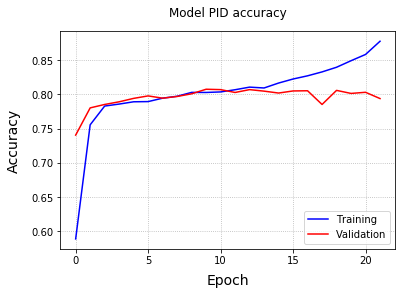

In [43]:
fig5 = plt.figure(5)
plt.plot(n_epochs, train_pid_acc, '-b', label='Training')
plt.plot(n_epochs, val_pid_acc, '-r', label='Validation')

plt.title('Model PID accuracy', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
plt.savefig(plotdir + 'pid_accuracy.png')
fig5.show()


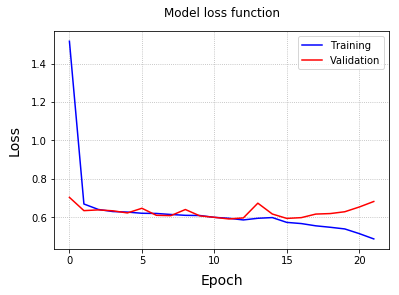

In [45]:
fig6 = plt.figure(6)
plt.plot(n_epochs, train_loss, '-b', label='Training')
plt.plot(n_epochs, val_loss, '-r', label='Validation')

plt.title('Model loss function', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.savefig(plotdir + 'total_loss.png')
fig6.show()

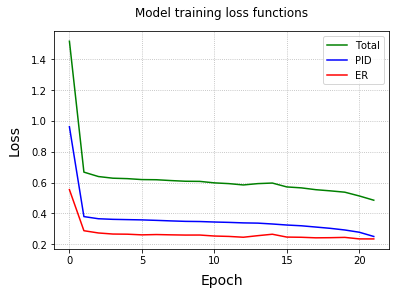

In [47]:
fig7 = plt.figure(7)
plt.plot(n_epochs, train_loss, '-g', label='Total')
plt.plot(n_epochs, train_pid_loss, '-b', label='PID')
plt.plot(n_epochs, train_en_loss, '-r', label='ER')


plt.title('Model training loss functions', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.savefig(plotdir + 'training_loss.png')
fig7.show()

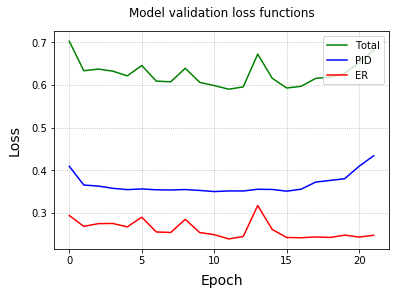

In [48]:
fig8 = plt.figure(8)
plt.plot(n_epochs, val_loss, '-g', label='Total')
plt.plot(n_epochs, val_pid_loss, '-b', label='PID')
plt.plot(n_epochs, val_en_loss, '-r', label='ER')


plt.title('Model validation loss functions', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.savefig(plotdir + 'validation_loss.png')
fig8.show()